UBER Pickup

L'objectif de ce projet est de créer une application pour aider les chauffeurs UBER à trouver des zones à forte densité pour améliorer la rentabilité de leur activité.

Une étude à été faite sur le temps d'attente maximum que respecte un client avant d'annuler sa commande : ce temps est de 5 a 7 minutes.

Il faut donc qu'un chauffeur UBER puisse trouver un nouveau client dans sa zone en moins de 7 min après avoir déposé son ancien client.

Pour cela, nous allons clusteriser les zones à forte densité pour recommander les meilleurs endroits.

Ce Dataset représente l'ensemble des courses sur une période allant d'avril 2014 à juin 2015 : chaque ligne est une course.

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from sklearn.cluster import DBSCAN, KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
import plotly
import pandas as pd
from plotly.graph_objs import Scattermapbox
import plotly.graph_objs as go
import plotly.io as pio
# pio.renderers.default = "svg"
pio.renderers.default = "iframe_connected"

Nous avons 7 datasets :</br>
* 6 datasets concernant les courses de chauffeurs UBER sur une durée de 6 mois, chaque dataset correspondant à un mois
* 1 dataset contenant les courses de janvier à juin 2015

In [2]:
df_apr14 = pd.read_csv('uber-raw-data-apr14_modified.csv')

In [3]:
df_apr14 = pd.read_csv('./src/uber-raw-data-apr14.csv')
df_may14 = pd.read_csv('./src/uber-raw-data-may14.csv')
df_jun14 = pd.read_csv('./src/uber-raw-data-jun14.csv')
df_jul14 = pd.read_csv('./src/uber-raw-data-jul14.csv')
df_aug14 = pd.read_csv('./src/uber-raw-data-aug14.csv')
df_sep14 = pd.read_csv('./src/uber-raw-data-sep14.csv')
df_janjune15 = pd.read_csv('./src/uber-raw-data-janjune-15.csv')

In [4]:
df_apr14.shape, df_may14.shape, df_jun14.shape, df_jul14.shape, df_aug14.shape, df_sep14.shape, df_janjune15.shape

((564516, 4),
 (652435, 4),
 (663844, 4),
 (796121, 4),
 (829275, 4),
 (1028136, 4),
 (14270479, 4))

On remarque un nombre croissant de courses de chauffeurs UBER en fonction du temps

In [4]:
df_apr14.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


Pour les datasets concernant la période de 2014, il y 4 colonnes:</br>
* **Date/Time** : La date et l'heure de la prise en charge d'un client par le chauffeur Uber au format mm/dd/yyyy h:m:s
* **Lat** : La latitude de la prise en charge d'un client par le chauffeur Uber
* **Lon** : La longitude de la prise en charge d'un client par le chauffeur Uber
* **Base** : Le code de la société de Base TLC affiliée au chauffeur Uber

Voici les codes de Base TLC :</br>
* **B02512** : Unter
* **B02598** : Hinter
* **B02617** : Weiter
* **B02682** : Schmecken
* **B02764** : Danach-NY

In [5]:
df_janjune15.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID
0,B02617,2015-05-17 09:47:00,B02617,141
1,B02617,2015-05-17 09:47:00,B02617,65
2,B02617,2015-05-17 09:47:00,B02617,100
3,B02617,2015-05-17 09:47:00,B02774,80
4,B02617,2015-05-17 09:47:00,B02617,90


Pour le dataset qui se déroule entre janvier 2015 et juin 2015, nous avons les colonnes suivantes:</br>
* **Dispatching_base_num** : Code de l'entreprise de Base TLC qui a expédié le chauffeur Uber
* **Pickup_date** : Date complète de la prise en charge du client par le chauffeur Uber au format yyyy-mm-dd h:m:s
* **Affiliated_base_num** : Code d'entreprise de base TLC qui récupère le chauffeur Uber
* **locationID** : ID du lieu de prise en charge du chauffeur Uber

### Creation des dates

On va créer les colonnes `month`, `day`, `day_name` et `hour` pour que nous puissions agréer les clusters par date.

In [7]:
merge_df = pd.DataFrame()
for df in [df_apr14, df_may14, df_jun14, df_jul14, df_aug14, df_sep14]:
   
    df['Date/Time'] = pd.to_datetime(df['Date/Time'])
    df['Date'] = df['Date/Time'].dt.strftime('%Y-%m-%d')
    df['month'] =  df['Date/Time'].dt.month 
    df['day_name'] = df['Date/Time'].dt.day_name()
    df['day'] = df['Date/Time'].dt.day
    df['hour'] = df['Date/Time'].dt.hour
    merge_df = pd.concat([merge_df,df],axis=0)

In [ ]:
df_apr14.to_csv('./src/uber-raw-data-apr14_modified.csv',index=False)
df_may14.to_csv('./src/uber-raw-data-may14_modified.csv',index=False)
df_jun14.to_csv('./src/uber-raw-data-jun14_modified.csv',index=False)
df_jul14.to_csv('./src/uber-raw-data-jul14_modified.csv',index=False)
df_aug14.to_csv('./src/uber-raw-data-aug14_modified.csv',index=False)
df_sep14.to_csv('./src/uber-raw-data-sep14_modified.csv',index=False)

In [6]:
merge_df.to_csv('merge_df.csv', index=False)

In [3]:
merge_df = pd.read_csv('merge_df.csv')

On va analyser différentes statistiques pour connaitre les valeurs minimales et maximales, les valeurs manquantes, la moyenne,ect..

In [8]:
merge_df.describe(include='all')

,Date/Time,Lat,Lon,Base,Date,month,day_name,day,hour
count,4534327,4.534327e+06,4.534327e+06,4534327,4534327,4.534327e+06,4534327,4.534327e+06,4.534327e+06
unique,260093,NaN,NaN,5,183,NaN,7,NaN,NaN
top,2014-04-07 20:21:00,NaN,NaN,B02617,2014-09-13,NaN,Thursday,NaN,NaN
freq,97,NaN,NaN,1458853,43205,NaN,755145,NaN,NaN
first,2014-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2014-09-30 22:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,4.073926e+01,-7.397302e+01,NaN,NaN,6.828703e+00,NaN,1.594337e+01,1.421831e+01
std,NaN,3.994991e-02,5.726670e-02,NaN,NaN,1.703810e+00,NaN,8.744902e+00,5.958759e+00
min,NaN,3.965690e+01,-7.492900e+01,NaN,NaN,4.000000e+00,NaN,1.000000e+00,0.000000e+00
25%,NaN,4.072110e+01,-7.399650e+01,NaN,NaN,5.000000e+00,NaN,9.000000e+00,1.000000e+01


On remarque plusieurs éléments intéressants :</br>
* **Date/Time** : la période est bien entre le 1er avril 2014 et le 30 septembre 2014. Il y a un pic des courses le 7 avril a 20:21 qui concernent 97 courses 
* **Lat/Lon** : tout à l'air normal (On est bien sur une délimitation de la ville de New-York(Staten Island, Queens, Manhattan, Brooklyn, Bronx) avec une zone de périmètre élargie autour de cette ville)
* **Base** : il y a bien 5 Bases en tout avec la Base B02617 qui représente 1/3 de la répartition totale
* **Date** : on voit un pic le 16 septembre 2014 qui regroupe 43205 courses : c'est environ 1/100 de tous les jours de courses (il y a eu 2 fois plus de courses ce jour la que les autres jours en moyenne)
* **Month** : les mois ont l'air d'etre assez uniforme au niveau de leur répartition de courses
* **day_name** : pareil pour les jours de la semaine (même si Thursday ressort le plus, il ne s'agit que d'1/7 des courses totales)
* **day** : On voit qu'il y a moins de courses en début de mois qu'en fin de mois mais cela reste assez faible comme écart
* **hour** : on observe moins de courses avant 12h qu'après (sachant que seulement 25% des courses se font entre 0h et 10h, contre 25% se faisant entre 19h et 23h)

In [10]:
merge_sample = merge_df.sample(500000)

In [11]:
merge_sample['month_name'] = merge_sample['month'].map({4:'April', 5:'May',6:'June',7:'July',8:'August',9:'September',10:'October'})

In [14]:
merge_sample['day'].sort_values()

37510      1
276294     1
460066     1
421770     1
38169      1
          ..
603464    31
277396    31
588701    31
588324    31
582333    31
Name: day, Length: 500000, dtype: int64

In [15]:
fig = go.Figure()

sorter_month_name = ['April', 'May', 'June', 'July', 'August', 'September', 'October']
sorter_day_name = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig.add_trace(
    go.Histogram(
        x = merge_sample['month_name'].sort_values(), nbinsx=12))

fig.add_trace(
    go.Histogram(
        x = merge_sample['day'].sort_values(), nbinsx=30,
        visible = False))

fig.add_trace(
    go.Histogram(
        x = merge_sample['day_name'], nbinsx=7,
        visible = False))

fig.add_trace(
    go.Histogram(
        x = merge_sample['hour'].sort_values(), nbinsx=24,
        visible = False))

fig.add_trace(
    go.Histogram(
        x = merge_sample['Date'].sort_values(), nbinsx=25,
        visible = False))


fig.update_layout(
        title = go.layout.Title(text = "Exploring different variables", x = 0.5),
        showlegend = False)

fig.update_layout(
    updatemenus = [go.layout.Updatemenu(
        active = 0,
        buttons = [
                    go.layout.updatemenu.Button(
                        label = "Month",
                        method = "update",
                        args = [{"visible" : [True, False, False, False, False]}]),
                    go.layout.updatemenu.Button(
                            label = "Day",
                            method = "update",
                            args = [{"visible" : [False, True, False, False, False]}]),
                    go.layout.updatemenu.Button(
                            label = "Day_name",
                            method = "update",
                            args = [{"visible" : [False, False, True, False, False]}]),
                    go.layout.updatemenu.Button(
                            label = "Hour",
                            method = "update",
                            args = [{"visible" : [False, False, False, True, False]}]),
                    go.layout.updatemenu.Button(
                            label = "Date",
                            method = "update",
                            args = [{"visible" : [False, False, False, False, True]}]) 
                ]
    )]
)

Sur ces graphiques, nous pouvons observer plusieurs phénomènes :

* Pour les `Dates`, on voit une évolution constante du nombre de courses d'un chauffeur UBER (avec un creux en juillet, qui doit s'expliquer peut être par le jour férier du 04 juillet) avec un pic vers le mois de septembre (donc juste après les vacances)

* En observant les `Months`, on repère une la même tendance constante d'évolution positive du nombre de clients

* Pour les `Days`, on remarque une très forte homogénité des jours (à part le 31 qui s'explique par le fait qu'il n'y en a que la moitié de l'année), il n'y a donc pas de jours qui se diférencient sur le nombre de courses

* Pour les `Hours`, on observe une augmentation constante entre 6h et 18h (qui correspond aux tranches horaires de travail) avec un pic vers les 7/8h et un autre entre 16/19h qui correspond à l'arrivée puis au départ de son travail

Faisons un test sur le mois d'`avril` 2014 au jour `1` et à l'heure `0`

In [10]:
df = df_apr14
df[(df['month']==4) & (df['day']==1) & (df['hour']==0)]

,Date/Time,Lat,Lon,Base,Date,month,day_name,day,hour
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,2014-04-01,4,Tuesday,1,0
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,2014-04-01,4,Tuesday,1,0
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,2014-04-01,4,Tuesday,1,0
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,2014-04-01,4,Tuesday,1,0
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,2014-04-01,4,Tuesday,1,0
...,...,...,...,...,...,...,...,...,...
554608,2014-04-01 00:15:00,40.7430,-73.9518,B02764,2014-04-01,4,Tuesday,1,0
554609,2014-04-01 00:21:00,40.7563,-73.9849,B02764,2014-04-01,4,Tuesday,1,0
554610,2014-04-01 00:26:00,40.7636,-73.9756,B02764,2014-04-01,4,Tuesday,1,0
554611,2014-04-01 00:42:00,40.7140,-74.0144,B02764,2014-04-01,4,Tuesday,1,0


In [11]:
merge_df.isna().sum()

Date/Time    0
Lat          0
Lon          0
Base         0
Date         0
month        0
day_name     0
day          0
hour         0
dtype: int64

Il n'y a pas de NaN values

On choisit cette fois-ci une journée entière (le 1er avril)

In [42]:
# Verification du nombre de threads pour éviter les ralentissements
from threadpoolctl import threadpool_info

print(threadpool_info())

[{'user_api': 'blas', 'internal_api': 'mkl', 'prefix': 'mkl_rt', 'filepath': 'C:\\Users\\david\\anaconda3\\Library\\bin\\mkl_rt.1.dll', 'version': '2021.4-Product', 'threading_layer': 'intel', 'num_threads': 4}, {'user_api': 'blas', 'internal_api': 'openblas', 'prefix': 'libopenblas', 'filepath': 'C:\\Users\\david\\anaconda3\\Lib\\site-packages\\scipy\\.libs\\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll', 'version': '0.3.17', 'threading_layer': 'pthreads', 'architecture': 'Haswell', 'num_threads': 8}, {'user_api': 'openmp', 'internal_api': 'openmp', 'prefix': 'vcomp', 'filepath': 'C:\\Users\\david\\anaconda3\\vcomp140.dll', 'version': None, 'num_threads': 8}, {'user_api': 'openmp', 'internal_api': 'openmp', 'prefix': 'libiomp', 'filepath': 'C:\\Users\\david\\anaconda3\\Library\\bin\\libiomp5md.dll', 'version': None, 'num_threads': 8}]


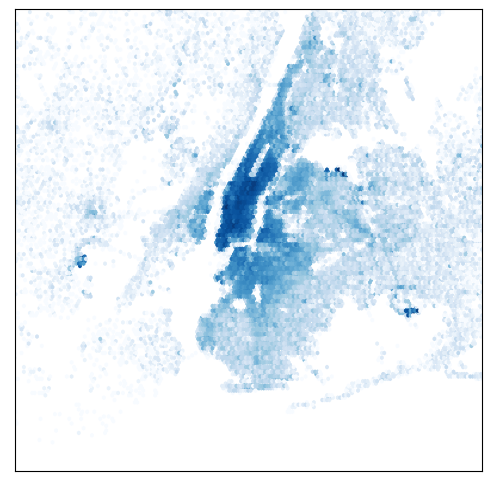

In [22]:
from mpl_toolkits.basemap import Basemap

west = -74.26 # Lon
south = 40.50 # Lat
east = -73.70 # Lon
north = 40.92 # Lat

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

m = Basemap(projection='merc',
            llcrnrlat=south,
            urcrnrlat=north,
            llcrnrlon=west,
            urcrnrlon=east,
            lat_ts=south,
            resolution='i')

x, y = m(merge_df['Lon'].values, merge_df['Lat'].values)

m.hexbin(x, y, gridsize=1000,
         bins='log', cmap=plt.cm.Blues);

On observe une forte densité de clients sur Manhattan principalement (puis sur les extérieurs bas de Manhattan : Queens et Brooklyn)